# Detecting the Ingroup and Outgroup of a text
---

In this notebook we test the performance for detecting the ingroup and outgroup of a text using the test data.

## Instantiate the Pipeline

In [3]:
%%time
import importlib
from cndlib import pipeline
# importlib.reload(cndlib.pipeline)
# cnd = pipeline.CND(extended = False)
cnd = pipeline.CND()

print(cnd.nlp.meta['name'])
print([pipe for pipe in cnd.nlp.pipe_names])

core_web_md
['tagger', 'parser', 'ner', 'Named Entity Matcher', 'merge_entities', 'Concept Matcher', 'merge_custom_chunks', 'hearst pattern matcher']
Wall time: 8.04 s


In [4]:
def is_group(span):
    
    keys = ["ingroup", "outgroup"]
    
    # capture entities with span_type of ingroup/outgroup
    if span._.span_type and span._.ATTRIBUTE in keys:
        return span._.ATTRIBUTE

    # capture entities with a hypernym with attribute of ingroup/outgroup
    if span.root._.has_hypernym:
        if span.root._.has_hypernym._.ATTRIBUTE in keys:
            return span.root._.has_hypernym._.ATTRIBUTE

    # capture entities which are an appositional modifier of an ingroup/outgroup span
    if span.root.dep_ == "appos" and span.root.head._.ATTRIBUTE in keys:
        return span.root.head._.ATTRIBUTE

    # capture conjunction entities which are an appositional modifier of an ingroup/outgroup span
    if span.root.dep_ == "conj" and span.root.head.dep_ == "appos" and span.root.head.head._.ATTRIBUTE in keys:
        return span.root.head.head._.ATTRIBUTE
    
    return "neutral"

100%|██████████| 248/248 [00:13<00:00, 18.28it/s]

gold list 1762 / 1762
predictable list 81 / 81


,gold_list,predictable list
neutral,1743,48
ingroup,14,15
outgroup,5,18


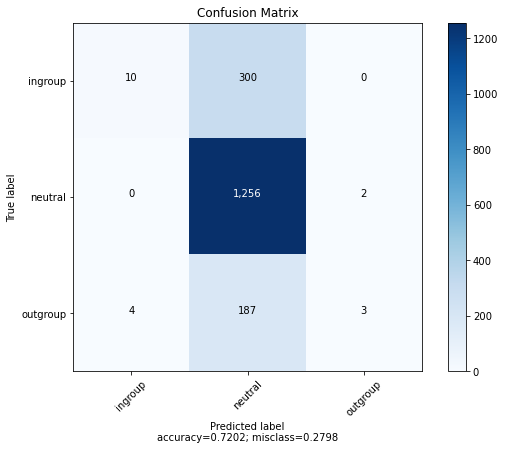

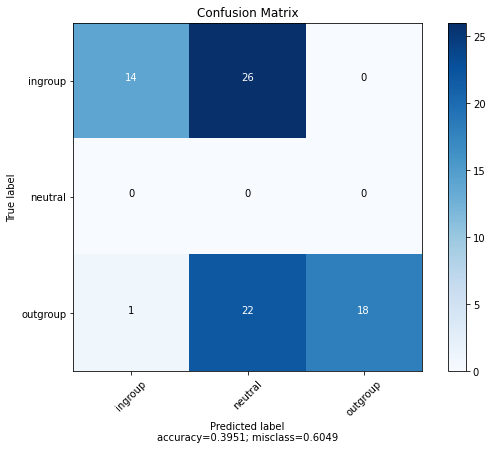

In [6]:
import os
import jsonlines
from tqdm import tqdm
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from cndlib.visuals import plot_confusion_matrix

## get the test data
path = os.getcwd()
gold_ents_filename = "gold_ents.jsonl"
gold_ents_filepath = os.path.join(path, gold_ents_filename)

with jsonlines.open(gold_ents_filepath) as f:
    gold_ents = list(f.iter())
    
gold_results = dict()
gold_detectable = dict()
ent_ref = 0
dect_ref = 0
chunking_error = 0


# iterate through the test data
for i, gold_ent in tqdm(enumerate(gold_ents), total = len(gold_ents)):
    
    temp = []
    
    for gold in gold_ent["gold_chunks"]:
        ent_ref += 1
        
        gold_results[ent_ref] = {"sentence" : i, "text": gold["text"].lower(), "gold" : "neutral", "pred" : "neutral"}
        
        if gold["grouping"]:
            gold_results[ent_ref]["gold"] = gold["grouping"]
        else:
            gold_results[ent_ref]["gold"] = "neutral"
        
        if gold["detectable"] == True:
            dect_ref += 1
            
            gold_detectable[dect_ref] = {"sentence" : i, "text": gold["text"].lower(), "gold" : gold["grouping"], "pred" : "neutral"}

    doc = cnd(gold_ent[str(i)])
    gold_temp = (ent_ref, [result["text"] for result in gold_results.values() if result["sentence"] == i])
    detectable_temp = (dect_ref, [result["text"] for result in gold_detectable.values() if result["sentence"] == i])
    chunks = [chunk.lower_ for chunk in cnd(gold_ent[str(i)])._.custom_chunks]
#     # print out chunking errors
#     if chunks != gold_temp[1]:
#         print(i, ') in chunk, not in golf:', [x for x in chunks if x not in gold_temp[1]])
#         print(i, ') in gold not in chunk:', [x for x in gold_temp[1] if x not in chunks])
#         print('-----')        
    
    for pred in doc._.custom_chunks:
        
        grouping = is_group(pred)
        
        if pred.lower_ in gold_temp[1]:
            gold_results[gold_temp[0]]["pred"] = grouping
        
        if pred.lower_ in detectable_temp[1]:
            gold_detectable[detectable_temp[0]]["pred"] = grouping

gold_list = [v["gold"] for v in gold_results.values()]
pred_list = [v["pred"] for v in gold_results.values()]
print("gold list", len(gold_list), '/', len(pred_list))

gold_detectable_list = [v["gold"] for v in gold_detectable.values()]
pred_detectable_list = [v["pred"] for v in gold_detectable.values()]
print("predictable list",len(gold_detectable_list), '/', len(pred_detectable_list))
display(pd.DataFrame({"gold_list" : Counter(pred_list), "predictable list" : Counter(pred_detectable_list)}))


plot_confusion_matrix(cm           = confusion_matrix(gold_list, pred_list), 
                      normalize    = False,
                      target_names = np.unique(pred_list),
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = confusion_matrix(gold_detectable_list, pred_detectable_list), 
                      normalize    = False,
                      target_names = np.unique(pred_detectable_list),
                      title        = "Confusion Matrix") 

# print(f1_score(gold_list, pred_list))
# print(f1_score(gold_detectable_list, pred_detectable_list))

In [9]:
import os
import jsonlines
from tqdm import tqdm
import pandas as pd
from cndlib.cndutils import display_side_by_side

path = os.getcwd()
gold_ents_filename = "gold_ents.jsonl"
gold_ents_filepath = os.path.join(path, gold_ents_filename)

with jsonlines.open(gold_ents_filepath) as f:
    gold_ents = list(f.iter())
    
gold_dict = {"ingroup" : [], "outgroup" : []}
pred_dict = {"ingroup" : [], "outgroup" : []}

count = {"noun_chunk_count" : 0,
          "hypernymy_count" : 0,
          "appos_count" : 0,
          "gold total" : 0}
results = {"tp" : 0,
           "fn" : 0,
           "fp" : 0}

def get_results(word, input_list, output_dict, show):
    if word in input_list:
        output_dict["tp"] += 1
        input_list.remove(word)
    else:
        output_dict["fn"] += 1
        show = True
    return input_list, output_dict, show
        

# for i, gold_ent in tqdm(enumerate(gold_ents), total = len(gold_ents)):
for i, gold_ent in enumerate(gold_ents):
    
    gold_dict = {"ingroup" : [], "outgroup" : []}
    pred_dict = {"ingroup" : [], "outgroup" : []}
    keys = list(pred_dict.keys())
    
    for gold in gold_ent["gold_chunks"]:
        if gold["grouping"] and gold["detectable"] == True:
            gold_dict[gold["grouping"]].append(gold["text"])
            count["gold total"] += 1
            
    gold_list = []
    for key in keys:
        gold_list += [group for group in gold_dict[key]]
            
    show = False
    doc = cnd(gold_ent[str(i)])
    for pred in doc._.custom_chunks:
        
        # capture entities with span_type of ingroup/outgroup
        if pred._.span_type and pred._.ATTRIBUTE in keys:
            pred_dict[pred._.ATTRIBUTE].append((pred[0], "chunk"))
            count["noun_chunk_count"] += 1
            gold_list, results, show = get_results(pred.text, gold_list, results, show)

        # capture entities with a hypernym with attribute of ingroup/outgroup
        if pred.root._.has_hypernym:
            if pred.root._.has_hypernym._.ATTRIBUTE in keys:
                pred_dict[pred.root._.has_hypernym._.ATTRIBUTE].append((pred[0], "hyp"))
                count["hypernymy_count"] += 1
                gold_list, results, show = get_results(pred.text, gold_list, results, show)
                
        # capture entities which are an appositional modifier of an ingroup/outgroup span
        if pred.root.dep_ == "appos" and pred.root.head._.ATTRIBUTE in keys:
            pred_dict[pred.root.head._.ATTRIBUTE].append((pred[0], "appos"))
            count["appos_count"] += 1
            gold_list, results, show = get_results(pred.text, gold_list, results, show)
        
        # capture conjunction entities which are an appositional modifier of an ingroup/outgroup span
        if pred.root.dep_ == "conj" and pred.root.head.dep_ == "appos" and pred.root.head.head._.ATTRIBUTE in keys:
            pred_dict[pred.root.head.head._.ATTRIBUTE].append((pred[0], "appos"))
            count["appos_count"] += 1
            gold_list, results, show = get_results(pred.text, gold_list, results, show)

    results["fp"] += len(gold_list)
    if gold_list: 
        print(i, gold_ent[str(i)])
        print(f'undetected:, {gold_list}, ({len(gold_list)}), ({results["fp"]})')
        print('-----')
#     if show or gold_list:
#         print(i, ':', doc)
#         df1 = pd.DataFrame({k : pd.Series(v, dtype = 'object') for k, v in gold_dict.items()}).fillna('')
#         df2 = pd.DataFrame({k : pd.Series(v, dtype = 'object') for k, v in pred_dict.items()}).fillna('')
#         display_side_by_side(df1, df2)
#         print('-----')
        
display(pd.DataFrame(count, index = ["count"]))
display(pd.DataFrame(results, index = ["result"]))
    
#     if any([len(v) > 0 for v in gold_dict.values()] + [len(v) > 0 for v in pred_dict.values()]):
#         print(i, ':', doc)
# #         chunk_data = {"chunks" : [chunk for chunk in doc._.custom_chunks], "attributes" : [chunk._.ATTRIBUTE for chunk in doc._.custom_chunks]}
# #         display(pd.DataFrame(chunk_data).T)
#         df1 = pd.DataFrame({k : pd.Series(v, dtype = 'object') for k, v in gold_dict.items()}).fillna('')
#         df2 = pd.DataFrame({k : pd.Series(v, dtype = 'object') for k, v in pred_dict.items()}).fillna('')
#         display_side_by_side(df1, df2)
#         print('-----')

12 America has no truer friend than Great Britain.
undetected:, ['Great Britain'], (1), (1)
-----
41 Our staunch friends, Great Britain, our neighbors Canada and Mexico, our NATO allies, our allies in Asia, Russia and nations from every continent on the Earth have offered help of one kind or another -- from military assistance to intelligence information, to crack down on terrorists' financial networks.
undetected:, ['Asia', 'Russia'], (2), (3)
-----
64 Together with friends and allies from Europe to Asia, and Africa to Latin America, we will demonstrate that the forces of terror cannot stop the momentum of freedom.
undetected:, ['Europe', 'Asia', 'Africa', 'Latin America'], (4), (7)
-----
67 Al Qaeda is to terror what the mafia is to crime.
undetected:, ['Al Qaeda'], (1), (8)
-----
77 These carefully targeted actions are designed to disrupt the use of Afghanistan as a terrorist base of operations and to attack the military capability of the Taliban regime.
undetected:, ['military capa

,noun_chunk_count,hypernymy_count,appos_count,gold total
count,44,9,12,81


,tp,fn,fp
result,43,22,38


In [6]:
import spacy
from spacy import displacy

text = "On my orders, the United States military has begun strikes against Al Qaeda terrorist training camps and military installations of the Taliban regime in Afghanistan"
text = "Terrorist groups like al Qaeda depend upon the aid or indifference of governments"
text = "But, thank God, the vast majority of the people, civilians and military, are aware of that sinister plan and will not allow themselves to be an instrument for strikes against one another in implementation of the policy of the main enemy, namely the Israeli-American alliance, through the Saudi regime, its agent in the country"
text = "There is no greater duty after faith than warding [daf'] off [that enemy], namely the Israeli-American alliance occupying the land of the two holy mosques and the land of the ascension of the Prophet, may God's prayers and blessings be upon him."
# text = "Today, the roles of Pharaoh, Caesar, and Chosroes have been taken up by Israel and United States, who first occupied our Aqsa Mosque, in the direction of which our Holy Prophet performed his prayers"
# text = "It is true that this shows that al-Qaida has gained, but on the other hand, it shows that the Bush administration has also gained, something of which anyone who looks at the size of the contracts acquired by the shady Bush administration-linked mega-corporations, like Halliburton and its kind, will be convinced."
text = "Both Americans and Muslim friends and citizens, tax-paying citizens, and Muslims in nations were just appalled and could not believe what -- what we saw on our TV screens."
nlp = spacy.load("en_core_web_sm")

def is_modifier(token):

    """
    function to determine whether a token modifies a span
    """

    tag_modifiers = ["JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS"]
    dep_modifiers = ["amod", "poss", "pobj", "npadvmod", "appos", "compound"]

    if token.tag_ in tag_modifiers and token.dep_ in dep_modifiers:
        return True
    return False

def get_span_modifier(span):

    """
    Getter function to for any modifying tokens of the root.
    """       

    word = span.root

    for token in span:
        # when the root is not a conjunct head, can iterate over terms to the left and right
        if is_modifier(token) and token.i != word.i:
            return token
        # when the root is a conjunct head, need to isolate only terms to its left
        # return itself as a modifier if no modifiers to the left
        elif token.conjuncts and token.dep_ != "conj":
            return token
    # if no modifier is found return the span root.
    return word

def get_span_type(span):
        
        """
        getter function to define the span entity type for any named entities modifying the root token
        
        iterates through left facing tokens to the root to identify any modifier terms
        returns: ent_type_ of any modifier named entities
        else returns the span root ent_type_
        """
        
        #iterate through the span and return any named concepts other than those related to the root.

        for token in span:
            if is_modifier(token) and token.ent_type_:
                return token.ent_type_
            
        return span.root.ent_type_

doc = cnd(text)
print('-----')
print([(t, get_span_modifier(t)) for t in nlp(text).noun_chunks])
print()
print([(t, t._.span_type) for t in doc._.custom_chunks])
# print(doc._.pairs)

for t in doc:
    if t.dep_ == "appos":
        print(t, '=>', t.head)
    if t.dep_ == "conj" and t.head.dep_ == "appos":
        print(t, '=>', t.head, '=>', t.head.head)

displacy.render(nlp(text), style = "dep")
print([(t, t.tag_) for t in nlp(text)])

-----
[(Both Americans, Americans), (Muslim friends, Muslim), (citizens, citizens), (tax-paying citizens, tax), (Muslims, Muslims), (nations, nations), (what, what), (what, what), (we, we), (our TV screens, TV)]

[(Americans, 'NORP'), (Muslim friends, 'NORP'), (citizens, ''), (tax-paying citizens, ''), (Muslims, 'NORP'), (nations, ''), (what, ''), (what, ''), (we, ''), (TV screens, '')]


[(Both, 'DT'), (Americans, 'NNPS'), (and, 'CC'), (Muslim, 'JJ'), (friends, 'NNS'), (and, 'CC'), (citizens, 'NNS'), (,, ','), (tax, 'NN'), (-, 'HYPH'), (paying, 'VBG'), (citizens, 'NNS'), (,, ','), (and, 'CC'), (Muslims, 'NNPS'), (in, 'IN'), (nations, 'NNS'), (were, 'VBD'), (just, 'RB'), (appalled, 'VBN'), (and, 'CC'), (could, 'MD'), (not, 'RB'), (believe, 'VB'), (what, 'WP'), (--, ':'), (what, 'WP'), (we, 'PRP'), (saw, 'VBD'), (on, 'IN'), (our, 'PRP$'), (TV, 'NN'), (screens, 'NNS'), (., '.')]
